# Task

The task is to build classifier using Convnets to classify [Simpsons](https://www.kaggle.com/competitions/journey-springfield) onto 42 classes

We are going to be using Deep Learning approach to this problem.

# Imports

In [1]:
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [2]:
# !pip install scikit-image

In [40]:
import copy
import os
import pickle
import time
import warnings
from functools import partial
from multiprocessing.pool import ThreadPool
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from matplotlib import colors
from matplotlib import pyplot as plt
from PIL import Image
from skimage import io
from sklearn.preprocessing import LabelEncoder
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from tqdm import tqdm, tqdm_notebook

%matplotlib inline

warnings.filterwarnings(action="ignore", category=DeprecationWarning)

# Global variables

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
SEED = 42

cuda


# Data preparation

## Reading data

Let's create two lists (for training and test data), in which we will store the paths to the pictures

In [5]:
TRAIN_DIR = Path("data/train")
TEST_DIR = Path("data/testset")
train_val_files = sorted(list(TRAIN_DIR.rglob("*.jpg")))
test_files = sorted(list(TEST_DIR.rglob("*.jpg")))
len(train_val_files), len(test_files)

(20933, 991)

We can access the class labels for the training data using the following method

In [6]:
train_val_files[0].parent.name

'abraham_grampa_simpson'

## Splitting data

In [7]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.20, stratify=train_val_labels, random_state=SEED)
train_labels_raw, val_labels_raw = [path.parent.name for path in train_files], [path.parent.name for path in val_files]

Immediately encode the class labels

In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(train_labels_raw)

train_labels = label_encoder.transform(train_labels_raw)
val_labels = label_encoder.transform(val_labels_raw)
test_labels = None

assert len(train_labels) == len(train_files)

class2label = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label2class = {v: k for k, v in class2label.items()}

## Transformations

In [9]:
val_test_trainsform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
train_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

data_transforms = {
    "train": train_transform,
    "val": val_test_trainsform,
    "test": val_test_trainsform,
}

## Dataset

It would be convenient to use the `datasets.ImageFolder` class, but we have data for training and validation in the same folder and it is not separated in advance, so we have to make it ourselves

In [10]:
class SimpsonsDataset(Dataset):
    def __init__(self, file_names, img_labels, mode, transform=None, target_transform=None):
        self.file_names = file_names
        self.img_labels = img_labels
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_path = str(self.file_names[idx])
        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)

        if self.mode == "test":
            return image
        else:
            label = self.img_labels[idx]

            if self.target_transform:
                label = self.target_transform(label)

            return image, label

In [11]:
train_dataset = SimpsonsDataset(train_files, train_labels, "train", data_transforms["train"])
val_dataset = SimpsonsDataset(val_files, val_labels, "val", data_transforms["val"])
test_dataset = SimpsonsDataset(test_files, test_labels, "test", data_transforms["test"])

image_datasets = {"train": train_dataset, "val": val_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}

Let's look at some examples from the training dataloader

In [12]:
dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

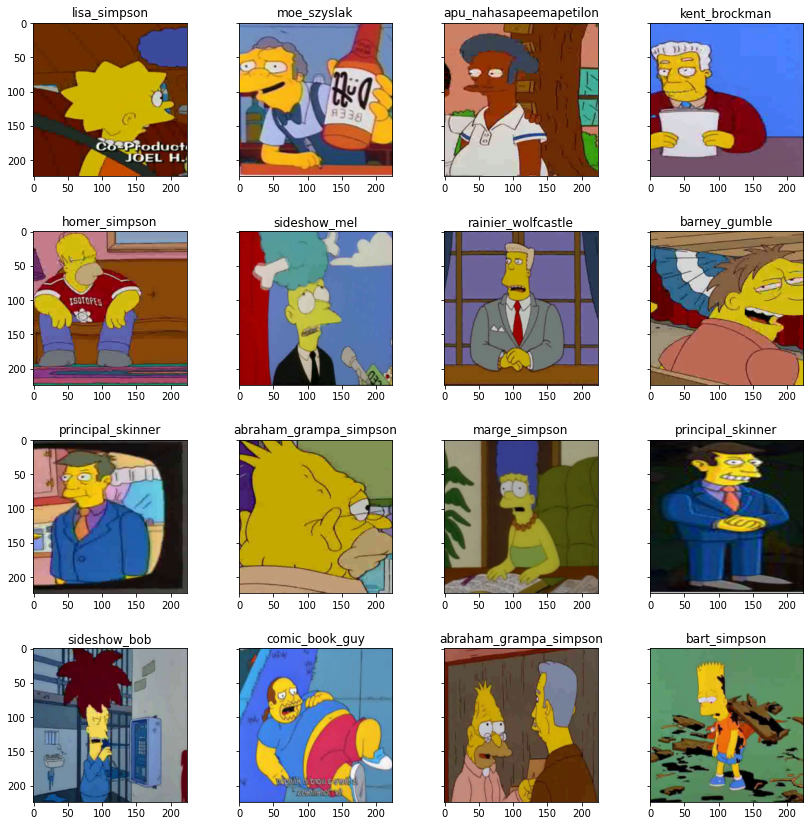

In [13]:
def imshow(inp, title=None, plt_ax=plt):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)


# Get a batch of training data
inputs, classes = next(iter(dataloader))
titles = [label2class[x] for x in classes.detach().numpy()]

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), sharey=True)

fig.tight_layout(pad=3.0)

i = 0
for ax in axs.flatten():
    imshow(inputs[i].cpu(), title=titles[i], plt_ax=ax)
    i += 1

## Hyperparameters

In [14]:
batch_size = 64
epochs = 10

## Dataloaders

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {"train": train_dataloader, "val": val_dataloader}

# Training the model

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm_notebook(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.type(torch.LongTensor).to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

We'll be using pretrained `vgg16_bn` model, for which we will finetune only the layer for classification

In [38]:
model_conv = torchvision.models.vgg16_bn(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_classes = len(class2label)
model_conv.classifier = nn.Linear(512 * 7 * 7, num_classes)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_conv.parameters(), lr=1e-3, amsgrad=True)
exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [39]:
model_ft = train_model(model_conv, criterion, optimizer, exp_lr_scheduler, num_epochs=epochs)

Epoch 0/9
----------


  0%|          | 0/262 [00:00<?, ?it/s]

train Loss: 1.0708 Acc: 0.7364


  0%|          | 0/66 [00:00<?, ?it/s]

val Loss: 0.6166 Acc: 0.8414

Epoch 1/9
----------


  0%|          | 0/262 [00:00<?, ?it/s]

train Loss: 0.2906 Acc: 0.9268


  0%|          | 0/66 [00:00<?, ?it/s]

val Loss: 0.5382 Acc: 0.8617

Epoch 2/9
----------


  0%|          | 0/262 [00:00<?, ?it/s]

train Loss: 0.1504 Acc: 0.9646


  0%|          | 0/66 [00:00<?, ?it/s]

val Loss: 0.5158 Acc: 0.8689

Epoch 3/9
----------


  0%|          | 0/262 [00:00<?, ?it/s]

train Loss: 0.0890 Acc: 0.9811


  0%|          | 0/66 [00:00<?, ?it/s]

val Loss: 0.4705 Acc: 0.8782

Epoch 4/9
----------


  0%|          | 0/262 [00:00<?, ?it/s]

train Loss: 0.0522 Acc: 0.9907


  0%|          | 0/66 [00:00<?, ?it/s]

val Loss: 0.4732 Acc: 0.8808

Epoch 5/9
----------


  0%|          | 0/262 [00:00<?, ?it/s]

train Loss: 0.0335 Acc: 0.9958


  0%|          | 0/66 [00:00<?, ?it/s]

val Loss: 0.4665 Acc: 0.8811

Epoch 6/9
----------


  0%|          | 0/262 [00:00<?, ?it/s]

train Loss: 0.0242 Acc: 0.9974


  0%|          | 0/66 [00:00<?, ?it/s]

val Loss: 0.4651 Acc: 0.8854

Epoch 7/9
----------


  0%|          | 0/262 [00:00<?, ?it/s]

train Loss: 0.0161 Acc: 0.9990


  0%|          | 0/66 [00:00<?, ?it/s]

val Loss: 0.4595 Acc: 0.8866

Epoch 8/9
----------


  0%|          | 0/262 [00:00<?, ?it/s]

train Loss: 0.0131 Acc: 0.9997


  0%|          | 0/66 [00:00<?, ?it/s]

val Loss: 0.4653 Acc: 0.8846

Epoch 9/9
----------


  0%|          | 0/262 [00:00<?, ?it/s]

train Loss: 0.0129 Acc: 0.9996


  0%|          | 0/66 [00:00<?, ?it/s]

val Loss: 0.4694 Acc: 0.8846

Training complete in 28m 7s
Best val Acc: 0.886554


# Predict test labels

In [44]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in tqdm_notebook(test_loader):
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [45]:
probs = predict(model_ft, test_dataloader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

  0%|          | 0/16 [00:00<?, ?it/s]

In [46]:
test_filenames = [path.name for path in test_dataset.file_names]

## Making a submission

In [48]:
submission = pd.read_csv("data/sample_submission.csv")
submission = pd.DataFrame({"Id": test_filenames, "Expected": preds}).sort_values("Id")
submission.to_csv("./submission.csv", index=False)